In [27]:
import pickle

import numpy as np
import random
import torch
import torchmetrics
import matplotlib.pyplot as plt

import util
from train import SegmentationDataset, mask_to_rgb_dict

from models.unet import UNet
from models.transunet import TransUNet

In [22]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
n_classes = len(mask_to_rgb_dict)

In [23]:
test_DS = SegmentationDataset(split_name="val", use_augmentation=False, normalize=False)

In [24]:
test_imgs = random.sample(range(len(test_DS)), 4)

(x1, y1) = test_DS[test_imgs[0]]
(x2, y2) = test_DS[test_imgs[1]]
(x3, y3) = test_DS[test_imgs[2]]
(x4, y4) = test_DS[test_imgs[3]]

x1_norm = util.normalize(x1).unsqueeze(0)
x2_norm = util.normalize(x2).unsqueeze(0)
x3_norm = util.normalize(x3).unsqueeze(0)
x4_norm = util.normalize(x4).unsqueeze(0);

In [6]:
iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes, average="macro")
precision = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average="macro")
recall = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average="macro")
f1 = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average="macro")

metrics = [iou, precision, recall, f1]

iou_per_class = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes, average="none")
precision_per_class = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average="none")
recall_per_class = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average="none")
f1_per_class = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average="none")

metrics_per_class = [iou_per_class, precision_per_class, recall_per_class, f1_per_class]

# 0. Elementary models

In [22]:
import importlib
importlib.reload(util);

In [58]:
import importlib
import models
importlib.reload(models)
from models.transunet import TransUNet
from models.unet import UNet

In [ ]:
model = torch.load("_trained_models/transunet/unet50", map_location="cpu")
torch.save(model.state_dict(), "trained_models/transunet/0/transunet50")

model = TransUNet(img_dim=512, class_num=n_classes)
model.load_state_dict(torch.load("trained_models/transunet/0/transunet50", map_location="cpu"))
model.eval();

## UNet

In [79]:
with open("trained_models/unet/0/loss", "rb") as file:
    loss = pickle.load(file)

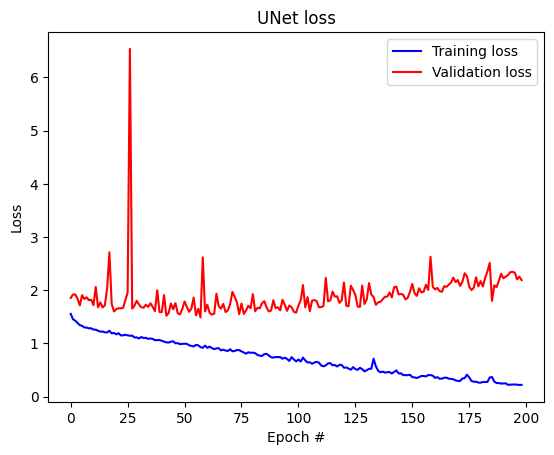

In [80]:
util.plot_loss(loss, title="UNet loss", up_to=200, save_name="unet0_loss")

In [11]:
model = UNet(n_classes)
model.load_state_dict(torch.load("trained_models/unet/0/unet_75"))
model.eval();

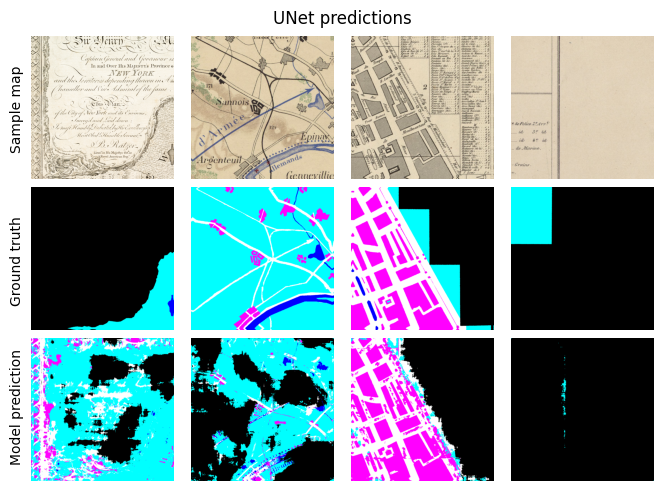

In [126]:
with torch.no_grad():
    pred1 = model(x1_norm)
    pred2 = model(x2_norm)
    pred3 = model(x3_norm)
    pred4 = model(x4_norm)

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="UNet predictions", save_name="unet0_pred")

In [128]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.18661603927612305
Mean Precision: 0.3449601491292318
Mean Recall: 0.28789895375569663
Mean F1: 0.25785245895385744


In [130]:
mean_metrics_per_class = []
for metric in metrics_per_class:
    mean_metric = util.mean_metric_per_class(model, test_DS, metric)
    mean_metrics_per_class.append(mean_metric)
print(mean_metrics_per_class)

[tensor([0.1986, 0.0634, 0.1539, 0.1496, 0.2274]), tensor([0.2461, 0.2584, 0.3664, 0.3691, 0.3820]), tensor([0.3562, 0.0721, 0.2462, 0.2945, 0.3605]), tensor([0.2367, 0.0913, 0.2260, 0.2299, 0.3315])]


In [26]:
[torch.tensor([1,2,3])

tensor([1, 2, 3])

## TransUNet

In [65]:
with open("trained_models/transunet/0/loss", "rb") as file:
    loss = pickle.load(file)

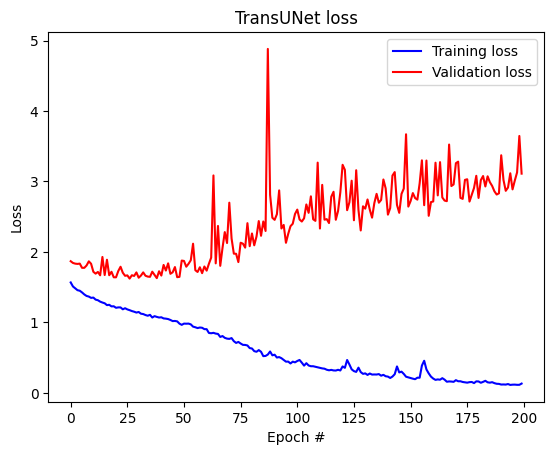

In [67]:
util.plot_loss(loss, title="TransUNet loss", up_to=200, save_name="transunet0_loss")

In [16]:
model = TransUNet(img_dim=512, class_num=n_classes)
model.load_state_dict(torch.load("trained_models/transunet/0/transunet50", map_location="cpu"))
model.eval();

C:\Users\Matěj\PycharmProjects\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


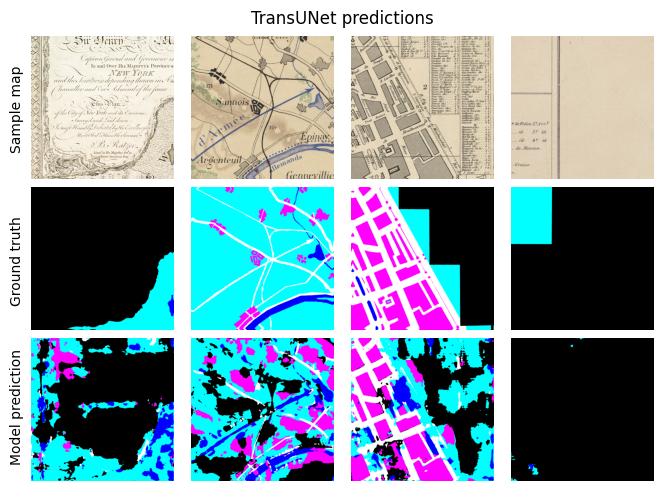

In [17]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="TransUNet predictions", save_name="transunet0_pred")

In [19]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.19869502709836376
Mean Precision: 0.36873611138791457
Mean Recall: 0.2936869251484774
Mean F1: 0.271587255049725


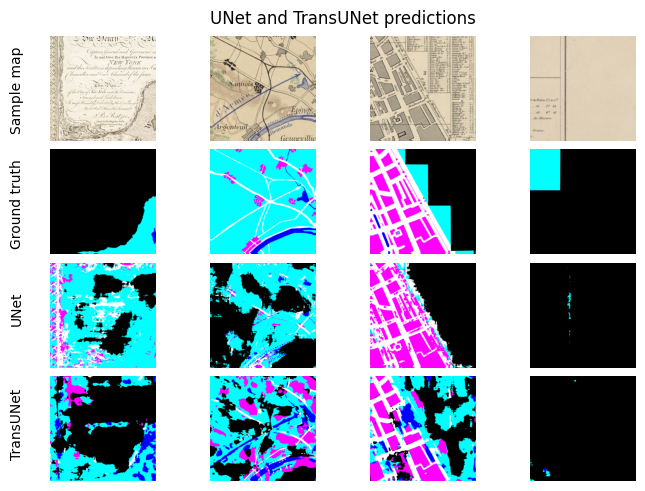

In [25]:
unet_model = UNet(n_classes)
unet_model.load_state_dict(torch.load("trained_models/unet/0/unet_75"))
unet_model.eval()

with torch.no_grad():
    unet_pred1 = unet_model(x1_norm)
    unet_pred2 = unet_model(x2_norm)
    unet_pred3 = unet_model(x3_norm)
    unet_pred4 = unet_model(x4_norm)

transunet_model = TransUNet(img_dim=512, class_num=n_classes)
transunet_model.load_state_dict(torch.load("trained_models/transunet/0/transunet50", map_location="cpu"))
transunet_model.eval()

with torch.no_grad():
    transunet_pred1 = transunet_model(util.downsize(x1_norm))
    transunet_pred2 = transunet_model(util.downsize(x2_norm))
    transunet_pred3 = transunet_model(util.downsize(x3_norm))
    transunet_pred4 = transunet_model(util.downsize(x4_norm))

fig, axs = plt.subplots(4, 4, constrained_layout=True)
fig.suptitle("UNet and TransUNet predictions")
fig.text(-0.02, 0.74, "Sample map", rotation=90)
fig.text(-0.02, 0.50, "Ground truth", rotation=90)
fig.text(-0.02, 0.34, "UNet", rotation=90)
fig.text(-0.02, 0.06, "TransUNet", rotation=90)
for i, x in enumerate([x1, x2, x3, x4]):
    ax = axs[0][i]
    ax.imshow(x.permute(1, 2, 0))
    ax.axis('off')
    ax.set_ylabel('hi')
for i, y in enumerate([y1, y2, y3, y4]):
    ax = axs[1][i]
    y = y.detach().numpy()
    rgb = np.zeros((*(y.shape), 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[y == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
for i, pred in enumerate([unet_pred1, unet_pred2, unet_pred3, unet_pred4]):
    ax = axs[2][i]
    pred = torch.argmax(pred, dim=1)
    pred = pred.squeeze(0)
    img = pred.numpy()
    rgb = np.zeros((*(y1.shape), 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[img == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
for i, pred in enumerate([transunet_pred1, transunet_pred2, transunet_pred3, transunet_pred4]):
    ax = axs[3][i]
    pred = torch.argmax(pred, dim=1)
    pred = pred.squeeze(0)
    img = pred.numpy()
    rgb = np.zeros((y.shape[0]//2, y.shape[1]//2, 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[img == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
fig.savefig('img/0_pred.png', bbox_inches="tight")

# 1. Transfer Learning

## UNet

In [57]:
with open("trained_models/unet/1_transfer_learning/loss", "rb") as file:
    loss = pickle.load(file)

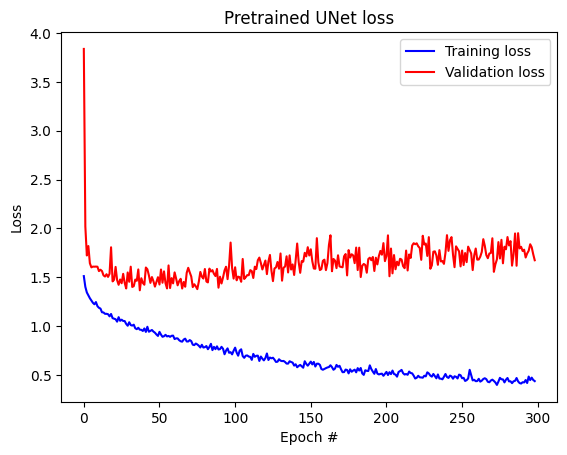

In [58]:
util.plot_loss(loss, title="Pretrained UNet loss", save_name="unet1_loss")

In [24]:
model = torch.load("trained_models/unet/1_transfer_learning/unet_40_full_model", map_location="cpu")
model.eval();

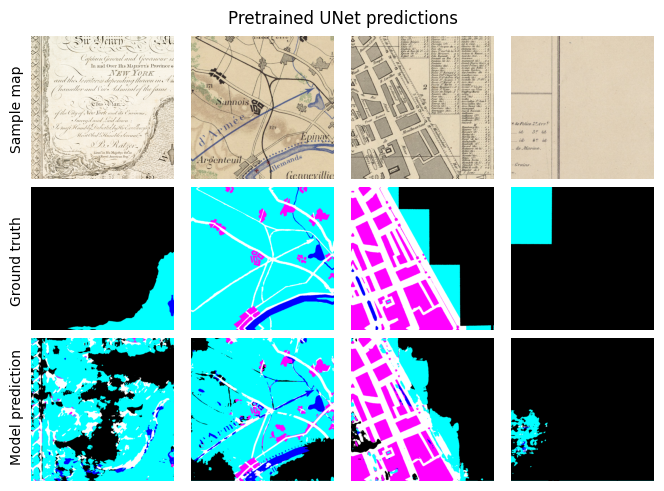

In [25]:
with torch.no_grad():
    pred1 = model(x1_norm)
    pred2 = model(x2_norm)
    pred3 = model(x3_norm)
    pred4 = model(x4_norm)

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Pretrained UNet predictions", save_name="unet1_pred")

In [26]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24598213117949816
Mean Precision: 0.39346570384745694
Mean Recall: 0.36482347760881695
Mean F1: 0.3168908333291813


In [34]:
with open("trained_models/transunet_augm/metrics", "rb") as file:
    transunet_augm_metrics = pickle.load(file)
print(transunet_augm_metrics)

with open("trained_models/transunet_augm/metrics_per_class", "rb") as file:
    transunet_augm_metric_per_class = pickle.load(file)
print(unet_metrics_per_class)

[tensor(0.2631), tensor(0.3899), tensor(0.3823), tensor(0.3431)]
[tensor([0.2403, 0.0702, 0.3144, 0.2436, 0.3679]), tensor([0.3173, 0.2450, 0.3999, 0.5354, 0.4369]), tensor([0.3163, 0.0833, 0.5735, 0.3294, 0.5965]), tensor([0.2749, 0.0974, 0.3954, 0.3455, 0.4715])]


## TransUNet

In [38]:
with open("trained_models/transunet/1_transfer_learning/loss", "rb") as file:
    loss = pickle.load(file)

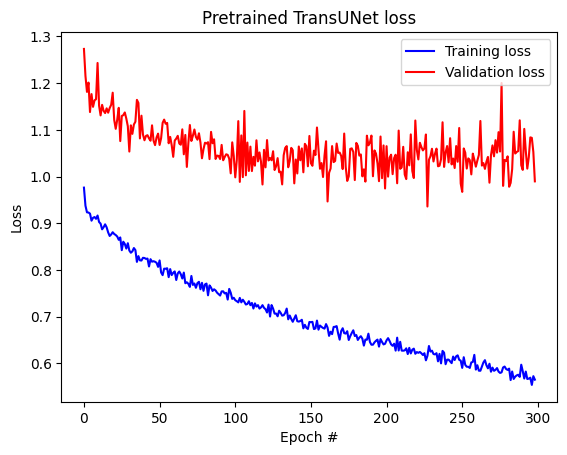

In [39]:
util.plot_loss(loss, title="Pretrained TransUNet loss", save_name="transunet1_loss")

In [14]:
model = TransUNet(img_dim=512, class_num=n_classes, pretrained=True)
model.load_state_dict(torch.load("trained_models/transunet/1_transfer_learning/transunet100", map_location="cpu"))
model.eval();

C:\Users\Matěj\PycharmProjects\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


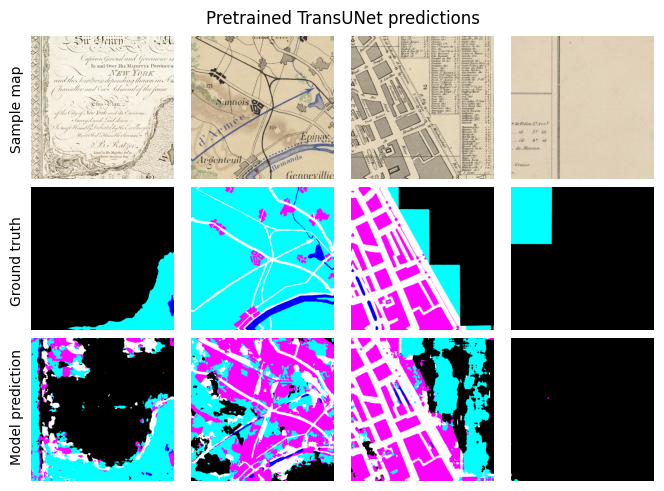

In [15]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Pretrained TransUNet predictions", save_name="transunet1_pred")

In [16]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24482368936344068
Mean Precision: 0.38236882735271843
Mean Recall: 0.3601536264224928
Mean F1: 0.32119741245191924


# 2. Data Augmentation

## UNet

In [72]:
with open("trained_models/unet/2_data_augmentation/loss", "rb") as file:
    loss = pickle.load(file)

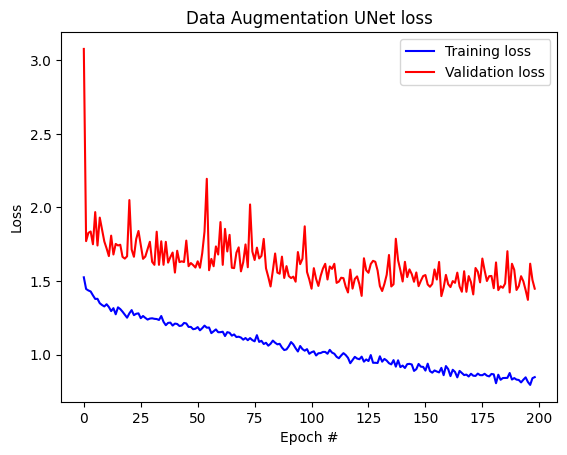

In [73]:
util.plot_loss(loss, title="Data Augmentation UNet loss", save_name="unet2_loss")

In [29]:
model = UNet(n_classes=n_classes)
model.load_state_dict(torch.load("trained_models/unet/2_data_augmentation/unet_150"))
model.eval();

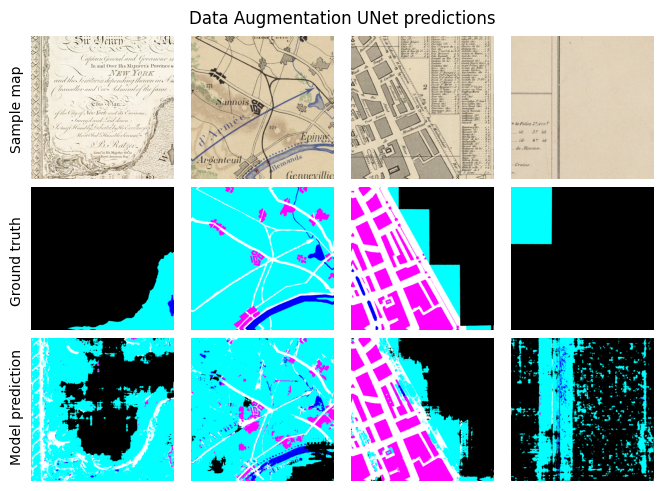

In [30]:
with torch.no_grad():
    pred1 = model(x1_norm)
    pred2 = model(x2_norm)
    pred3 = model(x3_norm)
    pred4 = model(x4_norm)

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Data Augmentation UNet predictions", save_name="unet2_pred")

In [31]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24676910711794484
Mean Precision: 0.39310603239098374
Mean Recall: 0.354478407879265
Mean F1: 0.32104091255032285


## TransUNet

In [42]:
with open("trained_models/transunet/2_data_augmentation/loss", "rb") as file:
    loss = pickle.load(file)

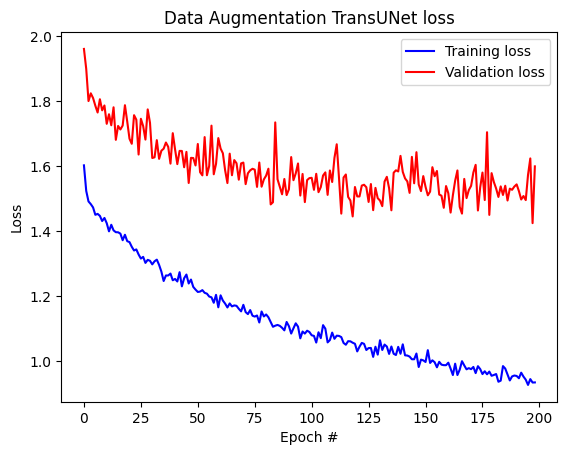

In [43]:
util.plot_loss(loss, title="Data Augmentation TransUNet loss", save_name="transunet2_loss")

In [17]:
model = TransUNet(img_dim=512, class_num=n_classes)
model.load_state_dict(torch.load("trained_models/transunet/2_data_augmentation/transunet50", map_location="cpu"))
model.eval();

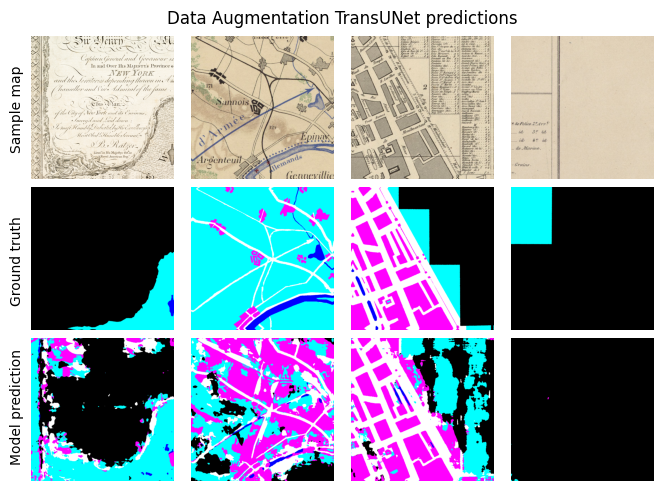

In [18]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Data Augmentation TransUNet predictions", save_name="transunet2_pred")

In [19]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24482368936344068
Mean Precision: 0.38236882735271843
Mean Recall: 0.3601536264224928
Mean F1: 0.32119741245191924


# 3. Learning Rate

## TransUNet (LR = 0.0001)

In [40]:
with open("trained_models/transunet/3_learning_rate/loss_0_0001", "rb") as file:
    loss = pickle.load(file)

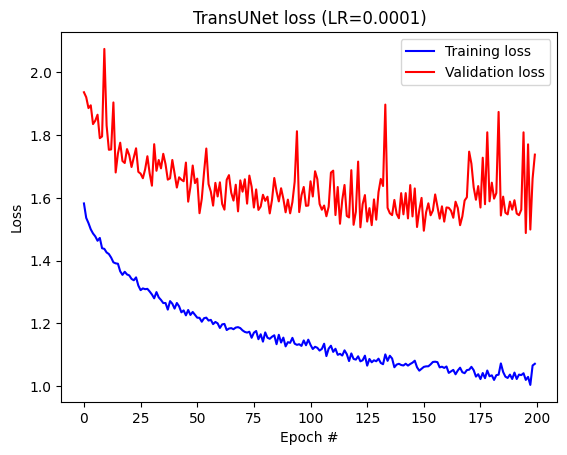

In [41]:
util.plot_loss(loss, title="TransUNet loss (LR=0.0001)", up_to=200, save_name="transunet3_loss_0_0001")

In [43]:
model = TransUNet(img_dim=512, class_num=n_classes)
model.load_state_dict(torch.load("trained_models/transunet/3_learning_rate/transunet50_0_0001", map_location="cpu"))
model.eval();

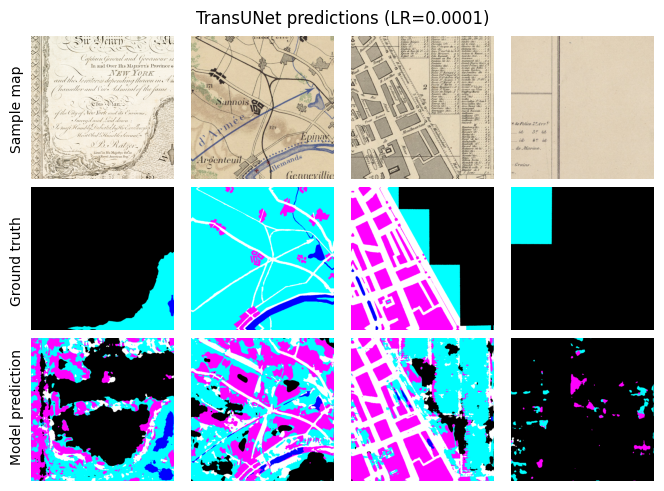

In [44]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="TransUNet predictions (LR=0.0001)", save_name="transunet3_pred_0_0001")

In [45]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.21858371033960458
Mean Precision: 0.350894460872728
Mean Recall: 0.33813449314662386
Mean F1: 0.295729753922443


## TransUNet (LR = 0.01)

In [53]:
with open("trained_models/transunet/3_learning_rate/loss_0_01", "rb") as file:
    loss = pickle.load(file)

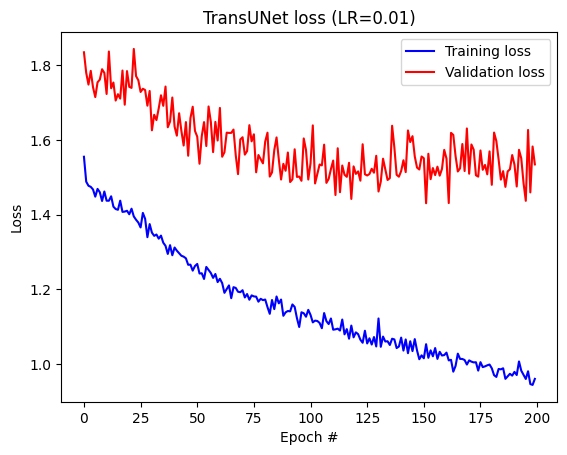

In [54]:
util.plot_loss(loss, title="TransUNet loss (LR=0.01)", up_to=200, save_name="transunet3_loss_0_01")

In [46]:
model = TransUNet(img_dim=512, class_num=n_classes)
model.load_state_dict(torch.load("trained_models/transunet/3_learning_rate/transunet100_0_01", map_location="cpu"))
model.eval();

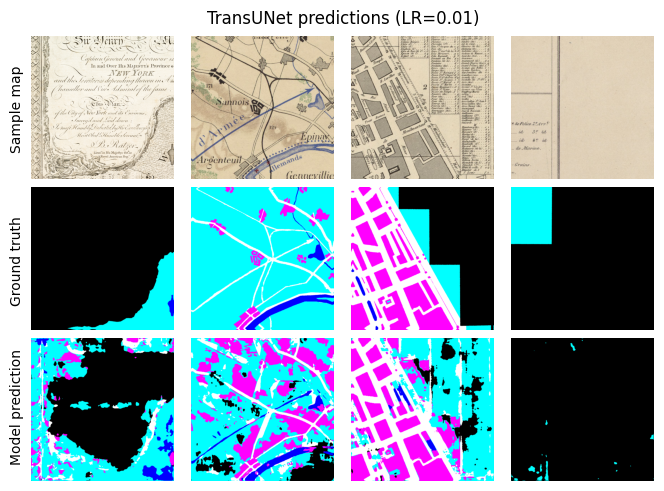

In [47]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="TransUNet predictions (LR=0.01)", save_name="transunet3_pred_0_01")

In [48]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24881615930674028
Mean Precision: 0.3883420593884526
Mean Recall: 0.3552766138193559
Mean F1: 0.3285453562833825


# 4. Leaky ReLU

In [8]:
with open("trained_models/unet/4_leaky_relu/loss", "rb") as file:
    loss = pickle.load(file)

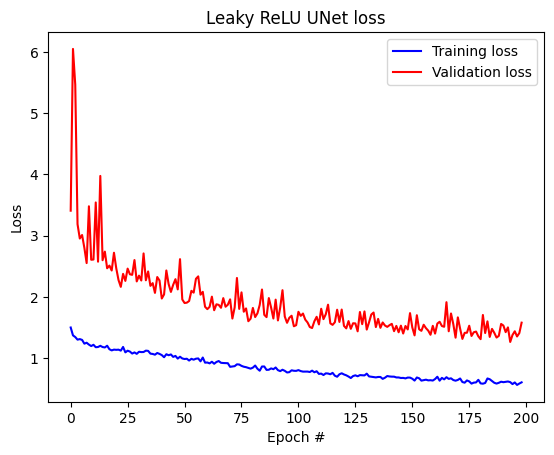

In [9]:
util.plot_loss(loss, title="Leaky ReLU UNet loss", save_name="unet4_loss")

In [11]:
model = UNet(n_classes=n_classes, leaky_relu=True)
model.load_state_dict(torch.load("trained_models/unet/4_leaky_relu/unet_150", map_location="cpu"))
model.eval();

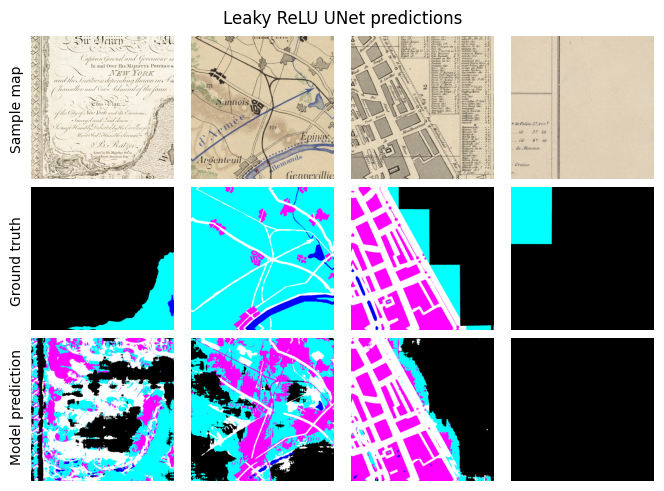

In [12]:
with torch.no_grad():
    pred1 = model(x1_norm)
    pred2 = model(x2_norm)
    pred3 = model(x3_norm)
    pred4 = model(x4_norm)

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Leaky ReLU UNet predictions", save_name="unet4_pred")

In [20]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric)
    mean_metrics.append(mean_metric)
util.print_metrics(mean_metrics)

Mean IOU: 0.24619384446192753
Mean Precision: 0.38931048137719461
Mean Recall: 0.3560127619300182
Mean F1: 0.31837491203846273


# Final models

In [7]:
test_DS = SegmentationDataset(split_name="test", use_augmentation=False, normalize=False)

In [8]:
test_imgs = random.sample(range(len(test_DS)), 4)

(x1, y1) = test_DS[test_imgs[0]]
(x2, y2) = test_DS[test_imgs[1]]
(x3, y3) = test_DS[test_imgs[2]]
(x4, y4) = test_DS[test_imgs[3]]

x1_norm = util.normalize(x1).unsqueeze(0)
x2_norm = util.normalize(x2).unsqueeze(0)
x3_norm = util.normalize(x3).unsqueeze(0)
x4_norm = util.normalize(x4).unsqueeze(0);

## UNet

In [9]:
with open("trained_models/unet/final/loss", "rb") as file:
    loss = pickle.load(file)

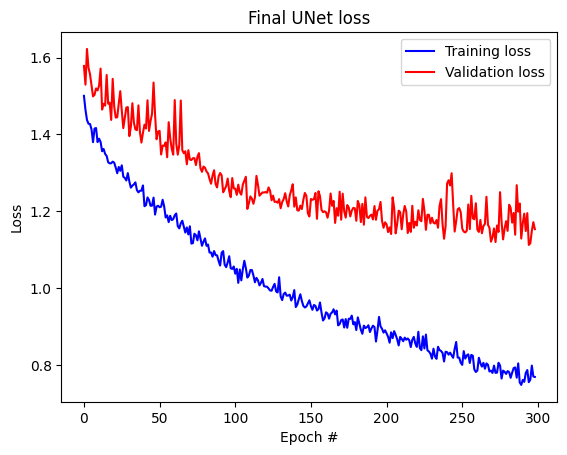

In [10]:
util.plot_loss(loss, title="Final UNet loss", save_name="unet_final_loss")

In [18]:
model = UNet(n_classes=n_classes, pretrained=True)
model.load_state_dict(torch.load("trained_models/unet/final/unet_200"))
model.eval();

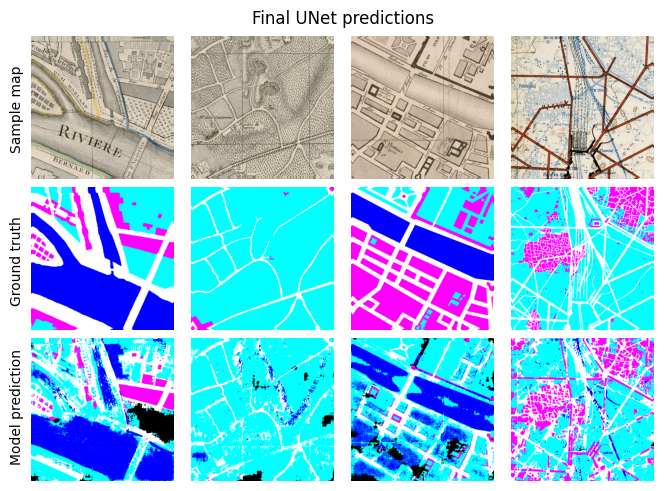

In [19]:
with torch.no_grad():
    pred1 = model(x1_norm)
    pred2 = model(x2_norm)
    pred3 = model(x3_norm)
    pred4 = model(x4_norm)

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4,
                    title="Final UNet predictions", save_name="final_unet_pred")

In [31]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric)
mean_metrics.append(mean_metric)

mean_metrics_per_class = []
for metric in metrics_per_class:
    mean_metric = util.mean_metric_per_class(model, test_DS, metric)
mean_metrics_per_class.append(mean_metric)

util.print_metrics(mean_metrics)
print(mean_metrics_per_class)

Mean IOU: 0.2759200096130371
Mean Precision: 0.427839994430542
Mean Recall: 0.4136000156402588
Mean F1 0.34503998756408694
[tensor([0.2845, 0.0823, 0.3528, 0.2983, 0.3617]), tensor([0.3439, 0.2999, 0.4539, 0.5823, 0.4592]), tensor([0.3528, 0.1038, 0.6143, 0.3355, 0.6616]), tensor([0.3193, 0.0994, 0.4124, 0.3911, 0.5030])]


In [ ]:
Mean IOU: 0.24598213117949816
Mean Precision: 0.39346570384745694
Mean Recall: 0.36482347760881695
Mean F1: 0.3168908333291813

In [ ]:
[tensor(0.24), tensor(0.3899), tensor(0.3823), tensor(0.3431)]
[tensor([0.2403, 0.0702, 0.3144, 0.2436, 0.3679]), tensor([0.3173, 0.2450, 0.3999, 0.5354, 0.4369]), tensor([0.3163, 0.0833, 0.5735, 0.3294, 0.5965]), tensor([0.2749, 0.0974, 0.3954, 0.3455, 0.4715])]

## TransUNet

In [13]:
with open("trained_models/transunet/final/loss", "rb") as file:
    loss = pickle.load(file)

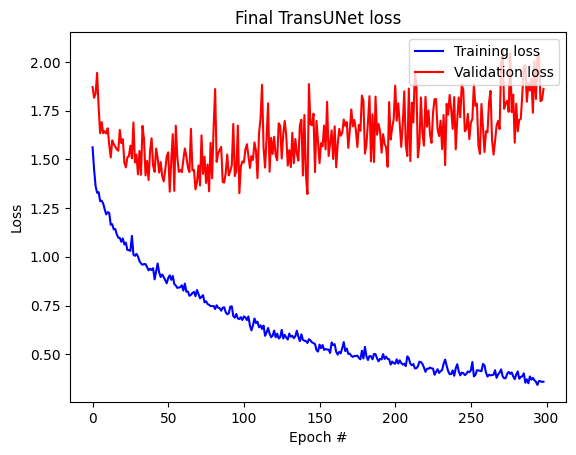

In [14]:
util.plot_loss(loss, title="Final TransUNet loss", save_name="transunet_final_loss")

In [15]:
model = TransUNet(img_dim=512, class_num=n_classes, pretrained=True)
model.load_state_dict(torch.load("trained_models/transunet/final/transunet_75"))
model.eval();

C:\Users\Matěj\PycharmProjects\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


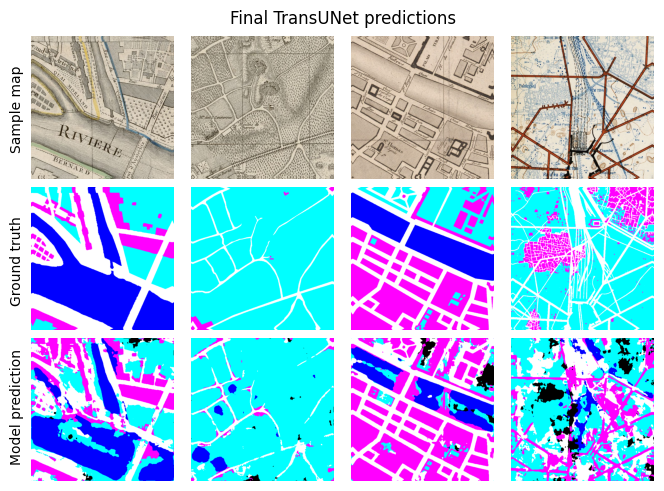

In [17]:
with torch.no_grad():
    pred1 = model(util.downsize(x1_norm))
    pred2 = model(util.downsize(x2_norm))
    pred3 = model(util.downsize(x3_norm))
    pred4 = model(util.downsize(x4_norm))

util.visualize_four(x1, x2, x3, x4, y1, y2, y3, y4, pred1, pred2, pred3, pred4, title="Final TransUNet predictions", save_name="transunet_final_pred")

In [32]:
mean_metrics = []
for metric in metrics:
    mean_metric = util.mean_metric(model, test_DS, metric, downsize_img=True)
mean_metrics.append(mean_metric)

mean_metrics_per_class = []
for metric in metrics_per_class:
    mean_metric = util.mean_metric_per_class(model, test_DS, metric, downsize_img=True)
mean_metrics_per_class.append(mean_metric)

util.print_metrics(mean_metrics)
print(mean_metrics_per_class)

Mean IOU: 0.2838600158691406
Mean Precision: 0.4326800346374512
Mean Recall: 0.42364001274108887
Mean F1 0.3411399841308594
[tensor([0.2941, 0.0855, 0.3516, 0.3104, 0.3777]), tensor([0.3532, 0.2856, 0.4759, 0.5912, 0.4575]), tensor([0.3616, 0.1154, 0.6249, 0.3440, 0.6723]), tensor([0.3042, 0.1034, 0.4242, 0.3611, 0.5128])]


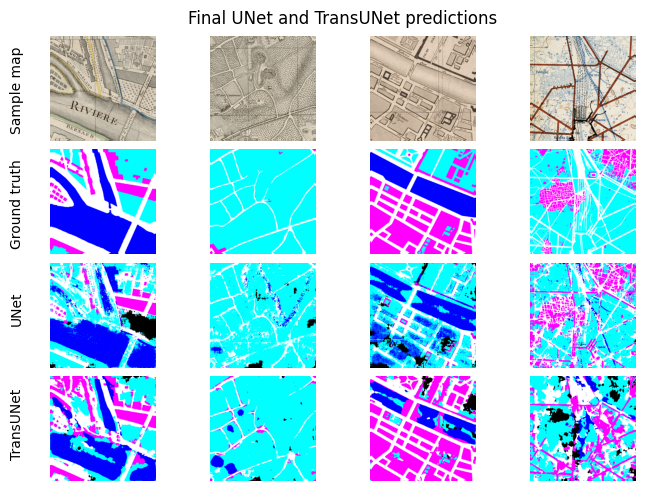

In [21]:
unet_model = UNet(n_classes=n_classes, pretrained=True)
unet_model.load_state_dict(torch.load("trained_models/unet/final/unet_200"))
unet_model.eval()

with torch.no_grad():
    unet_pred1 = unet_model(x1_norm)
    unet_pred2 = unet_model(x2_norm)
    unet_pred3 = unet_model(x3_norm)
    unet_pred4 = unet_model(x4_norm)

transunet_model = TransUNet(img_dim=512, class_num=n_classes, pretrained=True)
transunet_model.load_state_dict(torch.load("trained_models/transunet/final/transunet_75"))
transunet_model.eval()

with torch.no_grad():
    transunet_pred1 = transunet_model(util.downsize(x1_norm))
    transunet_pred2 = transunet_model(util.downsize(x2_norm))
    transunet_pred3 = transunet_model(util.downsize(x3_norm))
    transunet_pred4 = transunet_model(util.downsize(x4_norm))

fig, axs = plt.subplots(4, 4, constrained_layout=True)
fig.suptitle("Final UNet and TransUNet predictions")
fig.text(-0.02, 0.74, "Sample map", rotation=90)
fig.text(-0.02, 0.50, "Ground truth", rotation=90)
fig.text(-0.02, 0.34, "UNet", rotation=90)
fig.text(-0.02, 0.06, "TransUNet", rotation=90)
for i, x in enumerate([x1, x2, x3, x4]):
    ax = axs[0][i]
    ax.imshow(x.permute(1, 2, 0))
    ax.axis('off')
    ax.set_ylabel('hi')
for i, y in enumerate([y1, y2, y3, y4]):
    ax = axs[1][i]
    y = y.detach().numpy()
    rgb = np.zeros((*(y.shape), 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[y == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
for i, pred in enumerate([unet_pred1, unet_pred2, unet_pred3, unet_pred4]):
    ax = axs[2][i]
    pred = torch.argmax(pred, dim=1)
    pred = pred.squeeze(0)
    img = pred.numpy()
    rgb = np.zeros((*(y1.shape), 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[img == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
for i, pred in enumerate([transunet_pred1, transunet_pred2, transunet_pred3, transunet_pred4]):
    ax = axs[3][i]
    pred = torch.argmax(pred, dim=1)
    pred = pred.squeeze(0)
    img = pred.numpy()
    rgb = np.zeros((y.shape[0]//2, y.shape[1]//2, 3)).astype(np.uint8)
    for class_code, rgb_code in mask_to_rgb_dict.items():
        rgb[img == class_code, :] = rgb_code
    ax.imshow(rgb)
    ax.axis('off')
fig.savefig('img/final_pred.png', bbox_inches="tight")